In [2]:
import pickle
import numpy as np
import pandas as pd
from helper import *
from loading_models import *
from sklearn.linear_model import Ridge # for the blending
from test import load_data_sparse
import itertools # for feature expansion

## Data Exploration

Nbr Rate Per User
min: 3
max: 522
mean: 117.6952
Nbr Rate Per Film
min: 8
max: 4590
mean: 1176.952
(1000, 1)
<class 'pandas.core.frame.DataFrame'>


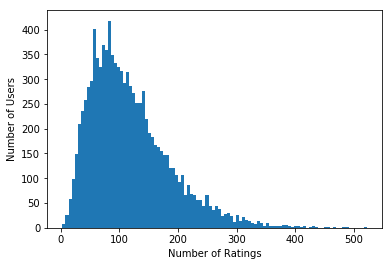

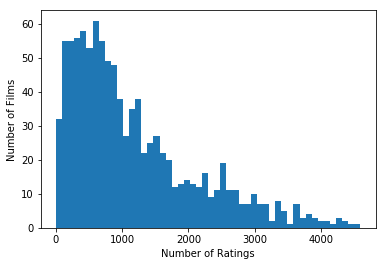

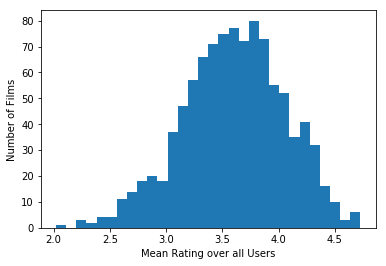

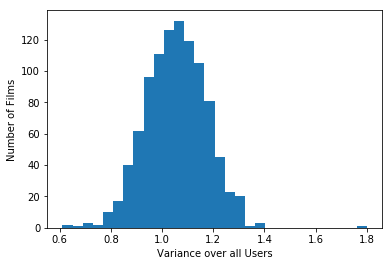

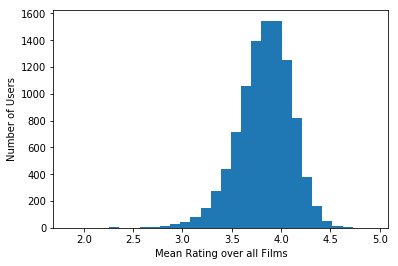

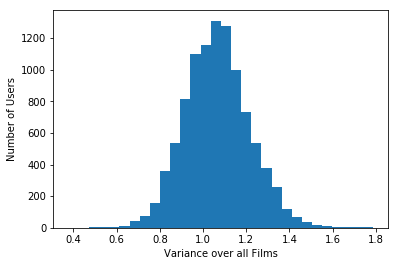

In [3]:
data_name = "data/47b05e70-6076-44e8-96da-2530dc2187de_data_train.csv"
ratings_sparse, ratings_pandas = load_data_sparse(data_name, True)

## Load the models

In [4]:
class Model:
    name = ''
    rmse = 0.0
    model = ''
    final_model = ''

In [5]:
labels = pickle.load(open('models/labels.pkl', 'rb'))
models = loadModels()

#### Compute RMSE for each model 

The ranking of the models will be done from the lower RMSE to the higher

In [6]:
for m in models:
    m.rmse = calculate_rmse(labels, m.model)

In [7]:
import operator
sorted_models = sorted(models, key=operator.attrgetter('rmse'))

In [8]:
for m in sorted_models:
    print('Model %s : %s' % (m.name,m.rmse))

Model als : 0.9842761153117054
Model bsknn : 0.9856890199729544
Model so : 0.9969080076726844
Model svdpp : 0.9974433490996525
Model svd : 0.997766335033669
Model basicknn : 1.0218854894245444
Model sgd : 1.0228761455871391
Model usermean : 1.0277625350651283
Model itemmean : 1.0933093510076437
Model usermedian : 1.0971948682814474
Model globalmean : 1.117181294724137
Model globalmedian : 1.1257663090048857
Model itemmedian : 1.1482061792157034
Model baseline : 1.2242112307678474


## Find the number of model to put in blending

In [66]:
# without feature expension

from sklearn.model_selection import train_test_split
rmse_test_evolution = []
rmse_train_evolution = []

# Build the prediction matrix
prediction = []

for m_id, m in enumerate(sorted_models): # 14
    if m_id == 0:
        prediction = m.model
    else:
        prediction = np.vstack((prediction,m.model))
        
prediction = pd.DataFrame(prediction)
prediction = np.transpose(prediction)
   
print(prediction.shape)  
X_train, X_test, y_train, y_test = train_test_split(prediction, labels, test_size=0.2)
print(X_train.shape)
print(X_test.shape) 

for i in range(len(sorted_models)):
    # Blending
    linreg = Ridge(alpha=0.1, fit_intercept=False)
    linreg.fit(X_train.iloc[:,0:i+1], y_train)
    #print(linreg.coef_) # print weight for each model
    
    rmse_tr = calculate_rmse(y_train, X_train.iloc[:,0:i+1].dot(linreg.coef_))
    rmse_te = calculate_rmse(y_test, X_test.iloc[:,0:i+1].dot(linreg.coef_))
    #print('With %s model(s) : %s' % (i+1,rmse))
    rmse_train_evolution.append(rmse_tr)
    rmse_test_evolution.append(rmse_te)
  

(117696, 14)
(94156, 14)
(23540, 14)


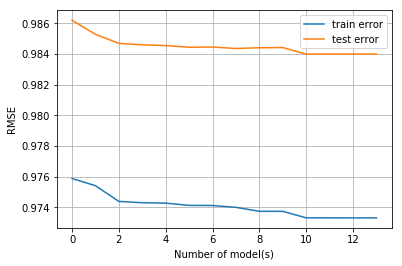

In [67]:
import matplotlib.pyplot as plt
plt.plot(range(len(rmse_train_evolution)),rmse_train_evolution)
plt.plot(range(len(rmse_test_evolution)),rmse_test_evolution)
plt.legend(['train error','test error'])
plt.xlabel('Number of model(s)')
plt.ylabel('RMSE')

plt.grid(True)
plt.savefig("test.png", bbox_inches='tight')

plt.show()

In [62]:
# with feature expension

from sklearn.model_selection import train_test_split
rmse_test_evolution = []
rmse_train_evolution = []

# Build the prediction matrix
prediction = []

for m_id, m in enumerate(sorted_models): # 14
    if m_id == 0:
        prediction = m.model
    else:
        prediction = np.vstack((prediction,m.model))
        
#prediction = pd.DataFrame(prediction)
prediction = np.transpose(prediction)
   
print(prediction.shape)  
X_train, X_test, y_train, y_test = train_test_split(prediction, labels, test_size=0.2)
print(X_train.shape)
print(X_test.shape) 

for i in range(len(sorted_models)):
    train = polynomial_features(X_train[:,0:i+1],2) # polynomial_features(prediction,2)
    # Blending
    linreg = Ridge(alpha=0.1, fit_intercept=False)
    linreg.fit(train, y_train)
    #print(linreg.coef_) # print weight for each model
    
    test = polynomial_features(X_test[:,0:i+1],2)
    rmse_tr = calculate_rmse(y_train, train.dot(linreg.coef_))
    rmse_te = calculate_rmse(y_test, test.dot(linreg.coef_))
    #print('With %s model(s) : %s' % (i+1,rmse))
    rmse_train_evolution.append(rmse_tr)
    rmse_test_evolution.append(rmse_te)
  

(117696, 14)
(94156, 14)
(23540, 14)


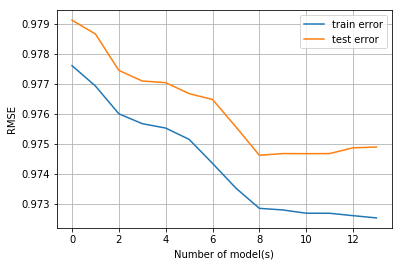

In [63]:
import matplotlib.pyplot as plt
plt.plot(range(len(rmse_train_evolution)),rmse_train_evolution)
plt.plot(range(len(rmse_test_evolution)),rmse_test_evolution)
plt.legend(['train error','test error'])
plt.xlabel('Number of model(s)')
plt.ylabel('RMSE')

plt.grid(True)
plt.savefig("test.png", bbox_inches='tight')

plt.show()

In [174]:
## with cross-validation
k_fold = 4
rmse_evolution = []

## Build the prediction matrix
prediction = []

for m_id, m in enumerate(sorted_models): # 14
    if m_id == 0:
        prediction = m.model
    else:
        prediction = np.vstack((prediction,m.model))
        
prediction = np.transpose(prediction)

## Split data for the cross-validation
# split data in k fold
labels = np.array(labels)
k_indices = build_k_indices(labels, k_fold)

for k in range(k_fold):
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    x_te = prediction[te_indice]
    y_te = labels[te_indice]

    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    x_tr = prediction[tr_indice]
    y_tr = labels[tr_indice]
    
    tmp_rmse_test_evolution = []
    tmp_rmse_train_evolution = []
    
    for i in range(len(sorted_models)):
        #train = polynomial_features(x_tr[:,0:i+1],2) # polynomial_features(prediction,2)
        # Blending
        linreg = Ridge(alpha=0.1, fit_intercept=False, random_state=1)
        linreg.fit(x_tr[:,0:i+1], y_tr)
        #print(linreg.coef_) # print weight for each model

        #test = polynomial_features(x_te[:,0:i+1],2)
        rmse_tr = calculate_rmse(y_tr, x_tr[:,0:i+1].dot(linreg.coef_))
        rmse_te = calculate_rmse(y_te, x_te[:,0:i+1].dot(linreg.coef_))
        #print('With %s model(s) : %s' % (i+1,rmse))
        
        rmse_evolution.append([i+1,rmse_tr,'train error'])
        rmse_evolution.append([i+1,rmse_te,'test error'])
        
rmse_evolution = pd.DataFrame(rmse_evolution)
rmse_evolution.columns = ['Number of model(s)','RMSE','Label'] 

[44828  5044 56809 ... 20463 18638 35683]


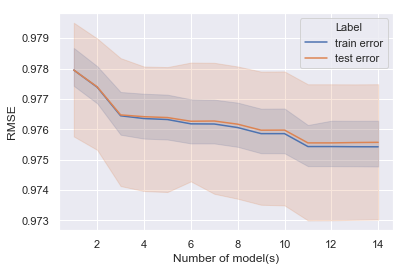

In [176]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.lineplot(x="Number of model(s)", y="RMSE", hue="Label", data=rmse_evolution)
plt.savefig("NbrModels.png", bbox_inches='tight')

In [171]:
## with cross-validation + feature expansion
k_fold = 4
rmse_evolution = []

## Build the prediction matrix
prediction = []

for m_id, m in enumerate(sorted_models): # 14
    if m_id == 0:
        prediction = m.model
    else:
        prediction = np.vstack((prediction,m.model))
        
prediction = np.transpose(prediction)

## Split data for the cross-validation
# split data in k fold
labels = np.array(labels)
k_indices = build_k_indices(labels, k_fold)

for k in range(k_fold):
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    x_te = prediction[te_indice]
    y_te = labels[te_indice]

    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    x_tr = prediction[tr_indice]
    y_tr = labels[tr_indice]
    
    tmp_rmse_test_evolution = []
    tmp_rmse_train_evolution = []
    
    for i in range(1,4):
        train = polynomial_features(x_tr,i) # polynomial_features(prediction,2)
        # Blending
        linreg = Ridge(alpha=0.1, fit_intercept=False)
        linreg.fit(train, y_tr)
        #print(linreg.coef_) # print weight for each model

        test = polynomial_features(x_te,i)
        rmse_tr = calculate_rmse(y_tr, train.dot(linreg.coef_))
        rmse_te = calculate_rmse(y_te, test.dot(linreg.coef_))
        #print('With %s model(s) : %s' % (i+1,rmse))
        
        rmse_evolution.append([i,rmse_tr,'train error'])
        rmse_evolution.append([i,rmse_te,'test error'])
    
rmse_evolution = pd.DataFrame(rmse_evolution) 
rmse_evolution.columns = ['Degree','RMSE','Label'] 

[44828  5044 56809 ... 20463 18638 35683]


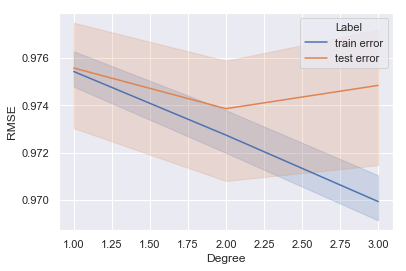

In [173]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.lineplot(x="Degree", y="RMSE", hue="Label", data=rmse_evolution)
plt.savefig("Degree.png", bbox_inches='tight')

In [11]:
best_nbrmodel = 11

## Final Blending

Define polynomial features fonction:

In [42]:
def polynomial_features(X, degree):
    """polynomial feature function that create a new features matrix with all combinations
    of features with degree less than or equal to the degree"""
    #get the number of samples and features from the X matrix
    nb_samples, nb_features = X.shape

    #create an iterator that lets us iterate over all combinations of numbers from 0 to nb_features-1
    combi = itertools.chain.from_iterable(
        itertools.combinations_with_replacement(range(nb_features), i) for i in range(degree + 1))

    #use that iterator to get the total number of features of the output
    nb_output = sum(1 for _ in combi)

    #initiate an empty array for the output
    PF = np.empty([nb_samples, nb_output])

    #instantiate the iterator again
    combi = itertools.chain.from_iterable(
        itertools.combinations_with_replacement(range(nb_features), i) for i in range(degree + 1))

    #create the polynomial features by iterating and multipliying the columns
    for a, b in enumerate(combi):
        PF[:, a] = X[:, b].prod(1)

    return PF

In [13]:
prediction = []
k_models = sorted_models[0:best_nbrmodel]
    
for m_id, m in enumerate(k_models):
    if m_id == 0:
        prediction = m.model
        prediction_final = m.final_model
    else:
        prediction = np.vstack((prediction,m.model))
        prediction_final = np.vstack((prediction_final,m.final_model))
    
if i != 0:
    prediction = np.transpose(prediction)
    prediction_final = np.transpose(prediction_final)
    
prediction = polynomial_features(prediction,2)
prediction_final = polynomial_features(prediction_final,2)
    
# Blending
linreg = Ridge(alpha=0.01, fit_intercept=False)
linreg.fit(prediction, labels)
print(linreg.coef_) # print weight for each model
    
rmse = calculate_rmse(labels, prediction.dot(linreg.coef_))

[ 8.06308989e-02  1.98237596e-01 -2.84423669e-02  7.80167560e-01
  1.12747240e-01 -3.21769940e-01 -1.13582958e-02 -1.10409045e-02
 -6.60549992e-01 -6.09325434e-01  7.10629471e-03  3.10926946e-01
 -2.24952624e-01  3.31260326e-01  1.11632045e+00 -1.94375031e-01
 -3.07528648e-02  2.26535173e-01 -4.48470549e-01 -6.77081556e-01
 -4.71739957e-01  3.78630582e-02  7.64551107e-01 -1.52322468e-01
  9.35204598e-02 -9.64346036e-02 -6.95602620e-02  6.40264565e-02
 -2.15072235e-01  3.97715909e-01 -2.43148996e-02  8.48240336e-03
 -1.09696026e-01  1.41559419e+00  1.85923658e-02 -3.50993893e-01
 -1.72134714e-01  1.49261805e-01 -3.32983759e+00 -3.40788403e+00
 -1.49059425e-01  3.00898741e+00  2.49226757e-01 -8.71773349e-01
 -5.59062610e-02  6.77396341e-01 -3.64244152e-01 -1.67498899e-01
  1.22171261e-01  4.34828217e-01 -4.42367813e-02 -5.18909628e-02
 -3.12125446e-01  1.26702122e+00  1.76910787e+00  1.34562281e-02
 -1.24099814e+00  5.26839700e-02  2.53133790e-01 -2.75214720e-01
 -1.07672577e-02 -1.40673

In [14]:
rmse

0.9729853705145273

#### Final prediction

In [15]:
final_result = []

for m_id in range(prediction_final.shape[1]):
    if m_id == 0:
        final_result = linreg.coef_[m_id] * prediction_final[:,m_id]
    else:
        final_result = final_result + linreg.coef_[m_id] * prediction_final[:,m_id]

print(final_result.shape)

'''
final_result = []

for m_id, m in enumerate(sorted_models):
    if m_id == 0:
        final_result = linreg.coef_[m_id] * m.final_model
    else:
        final_result = final_result + linreg.coef_[m_id] * m.final_model

print(final_result.shape)
'''

(1176952,)


'\nfinal_result = []\n\nfor m_id, m in enumerate(sorted_models):\n    if m_id == 0:\n        final_result = linreg.coef_[m_id] * m.final_model\n    else:\n        final_result = final_result + linreg.coef_[m_id] * m.final_model\n\nprint(final_result.shape)\n'

#### Create Submission

In [17]:
create_submission_from_prediction(final_result, 'test.csv')